In [435]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [436]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_squared_error

In [84]:
# load chocolate_chocolate_chocolate_data
# since the timestamp starts at 0, we should more one timestamp more for every day

prices_d0 = pd.read_csv('data/prices_round_3_day_0.csv', delimiter=';')
prices_d1 = pd.read_csv('data/prices_round_3_day_1.csv', delimiter=';')
prices_d1["timestamp"] += prices_d0["timestamp"].iloc[-1] + 100
prices_d2 = pd.read_csv('data/prices_round_3_day_2.csv', delimiter=';')
prices_d2["timestamp"] += prices_d1["timestamp"].iloc[-1] + 100

prices = pd.concat([prices_d0, prices_d1, prices_d2])


In [438]:
prices

day  timestamp       product  bid_price_1  bid_volume_1  bid_price_2  \
0        0          0     CHOCOLATE         7999           111          NaN   
1        0          0  STRAWBERRIES         3999           210          NaN   
2        0          0         ROSES        14999            72          NaN   
3        0          0   GIFT_BASKET        71348            19      71347.0   
4        0        100   GIFT_BASKET        71344             1      71343.0   
...    ...        ...           ...          ...           ...          ...   
39995    2    2999800   GIFT_BASKET        69537             2      69536.0   
39996    2    2999900     CHOCOLATE         7749           143          NaN   
39997    2    2999900   GIFT_BASKET        69551             1      69550.0   
39998    2    2999900  STRAWBERRIES         3984           240          NaN   
39999    2    2999900         ROSES        14411            59          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0               NaN          NaN           NaN         8001           111   
1               NaN          NaN           NaN         4001           210   
2               NaN          NaN           NaN        15001            72   
3              24.0          NaN           NaN        71362            19   
4              12.0      71342.0          20.0        71355             1   
...             ...          ...           ...          ...           ...   
39995          18.0      69535.0          24.0        69547             2   
39996           NaN          NaN           NaN         7751           143   
39997          19.0      69549.0          20.0        69561             1   
39998           NaN          NaN           NaN         3985            92   
39999           NaN          NaN           NaN        14412            59   

       ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0              NaN           NaN          NaN           NaN     8000.0   
1              NaN           NaN          NaN           NaN     4000.0   
2              NaN           NaN          NaN           NaN    15000.0   
3          71363.0          24.0          NaN           NaN    71355.0   
4          71356.0          12.0      71357.0          20.0    71349.5   
...            ...           ...          ...           ...        ...   
39995      69548.0          18.0      69550.0          24.0    69542.0   
39996          NaN           NaN          NaN           NaN     7750.0   
39997      69562.0          19.0      69564.0          20.0    69556.0   
39998       3986.0         148.0          NaN           NaN     3984.5   
39999          NaN           NaN          NaN           NaN    14411.5   

       profit_and_loss  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
39995              0.0  
39996              0.0  
39997              0.0  
39998              0.0  
39999              0.0  

[120000 rows x 17 columns]

In [439]:
prices["mid_price"] = (prices["ask_price_1"] + prices["bid_price_1"])/2


In [440]:
trades_d0 = pd.read_csv('data/trades_round_3_day_0_nn.csv', delimiter=';')
trades_d1 = pd.read_csv('data/trades_round_3_day_1_nn.csv', delimiter=';')
trades_d1["timestamp"] += trades_d0["timestamp"].iloc[-1] + 100
trades_d2 = pd.read_csv('data/trades_round_3_day_2_nn.csv', delimiter=';')
trades_d2["timestamp"] += trades_d1["timestamp"].iloc[-1] + 100

trades = pd.concat([trades_d0, trades_d1, trades_d2])

# del trades_d0, trades_d1, trades_d2

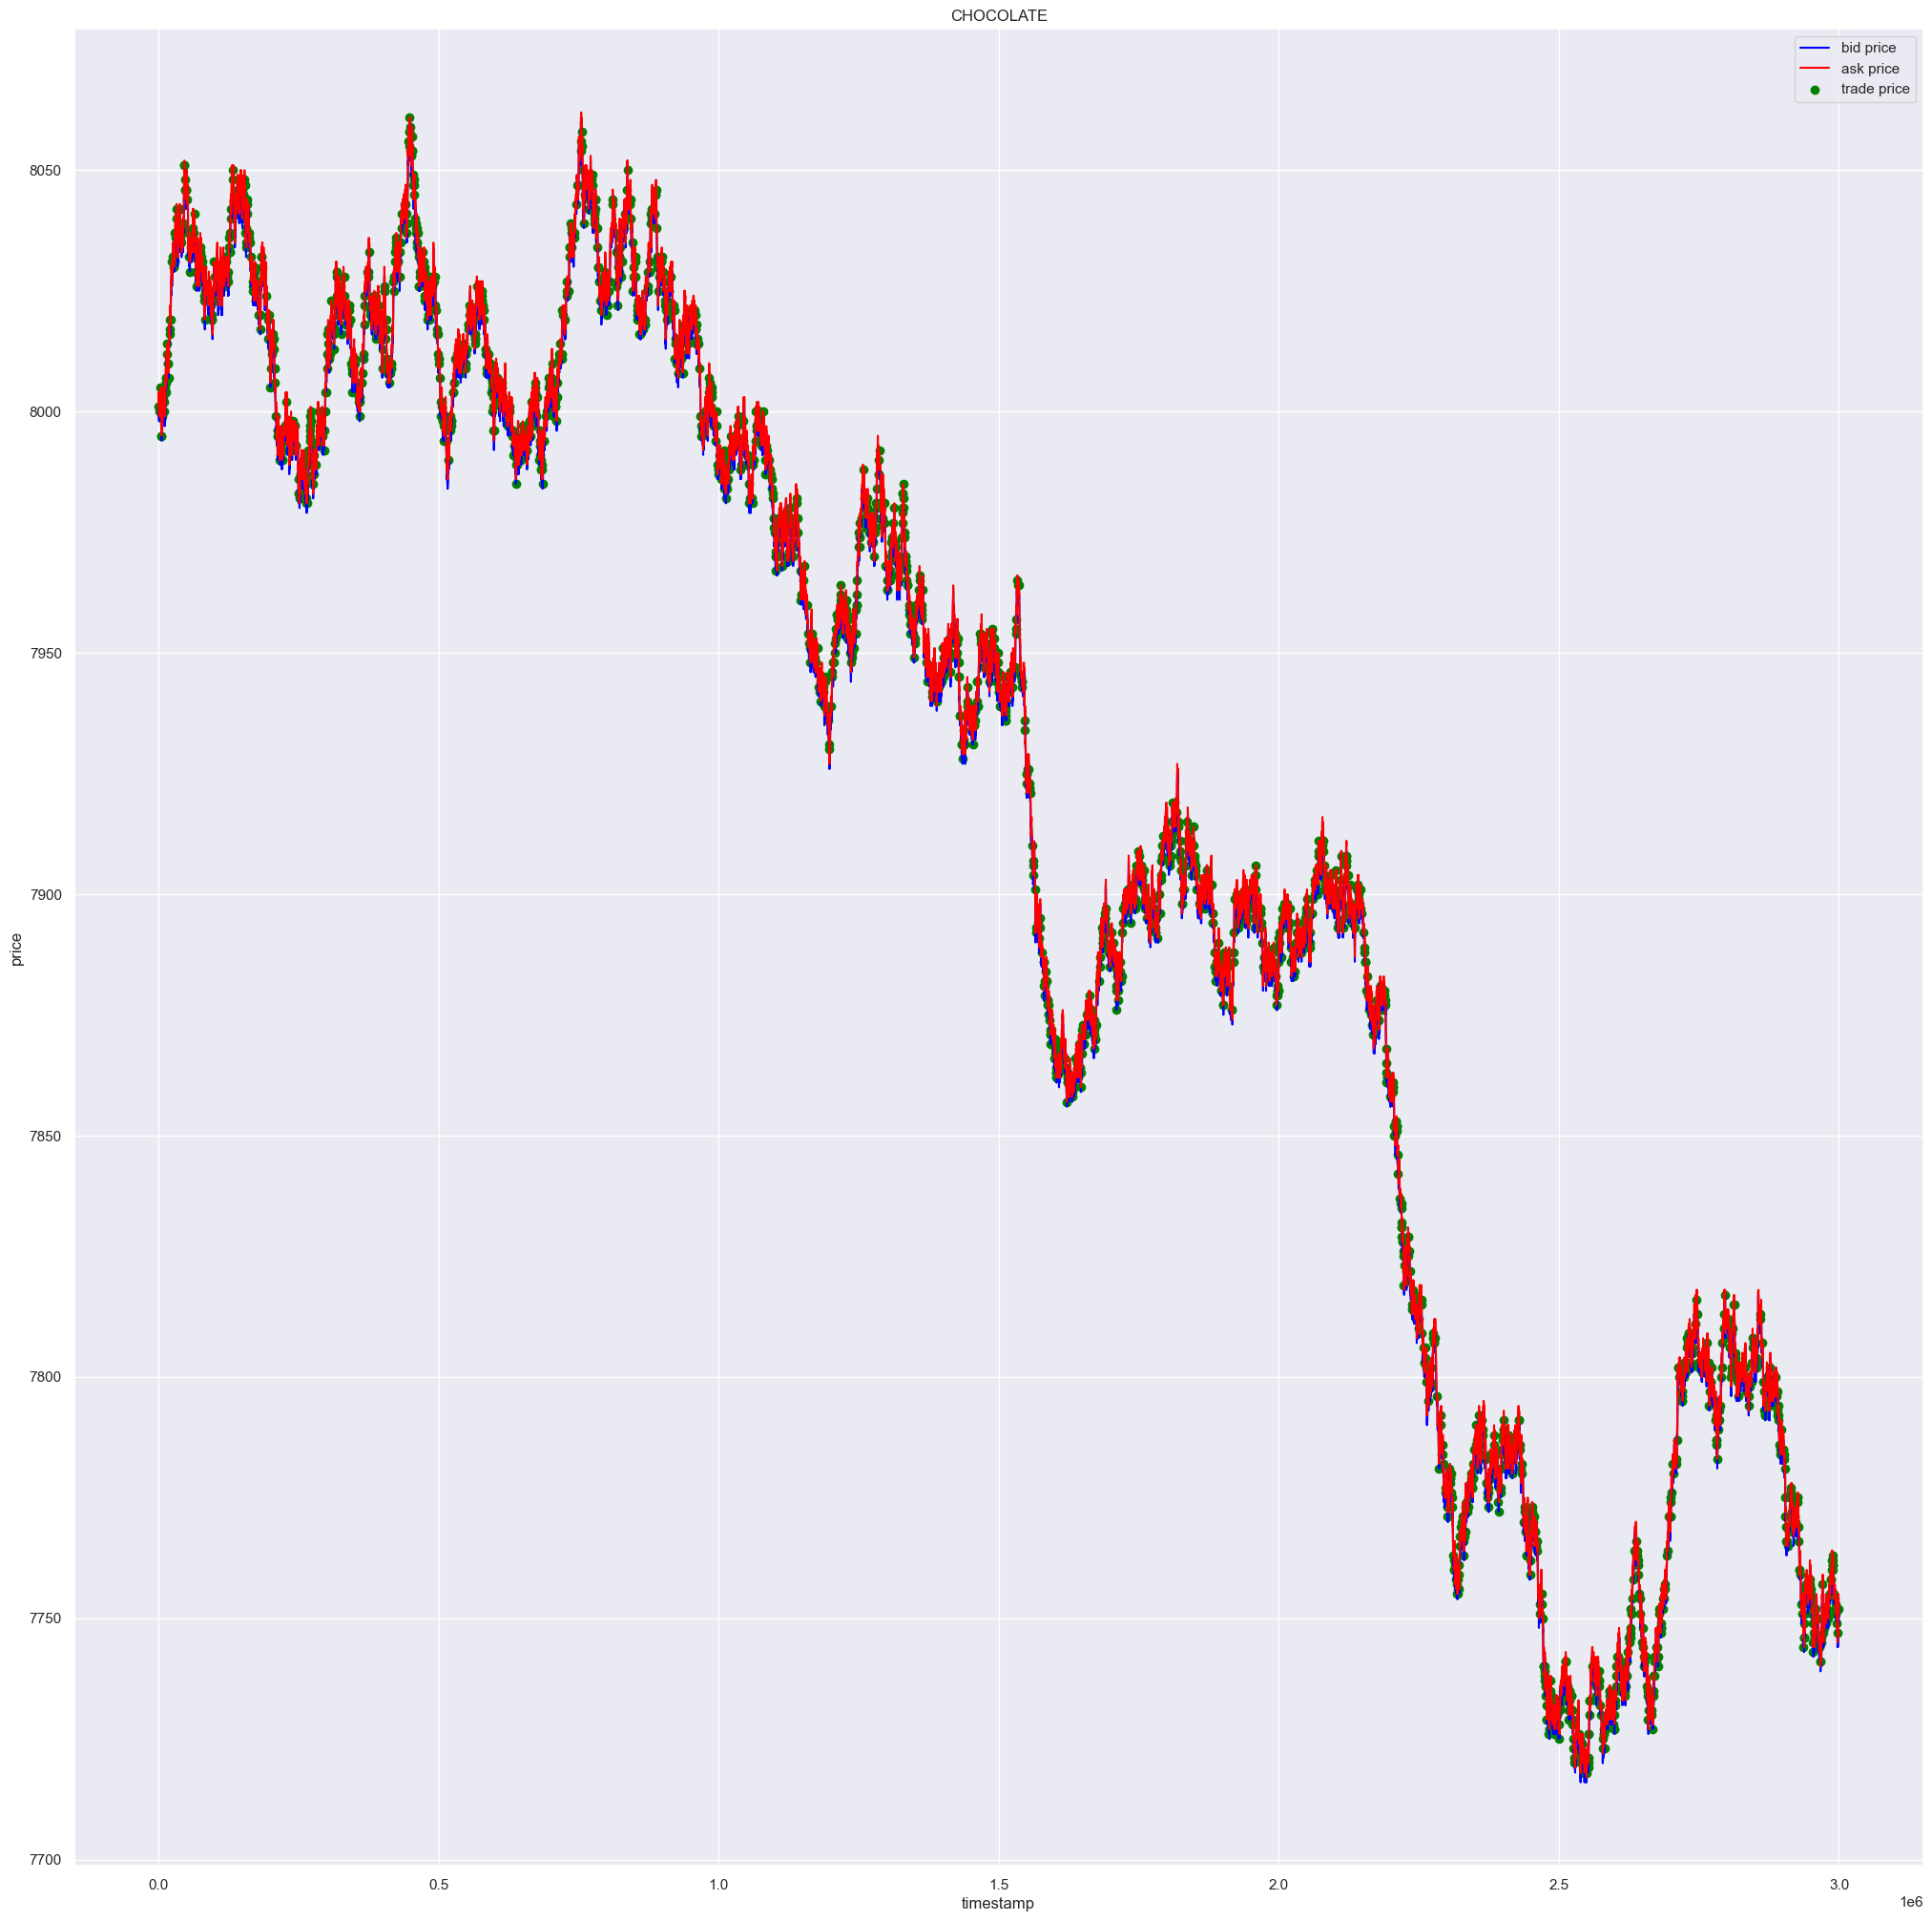

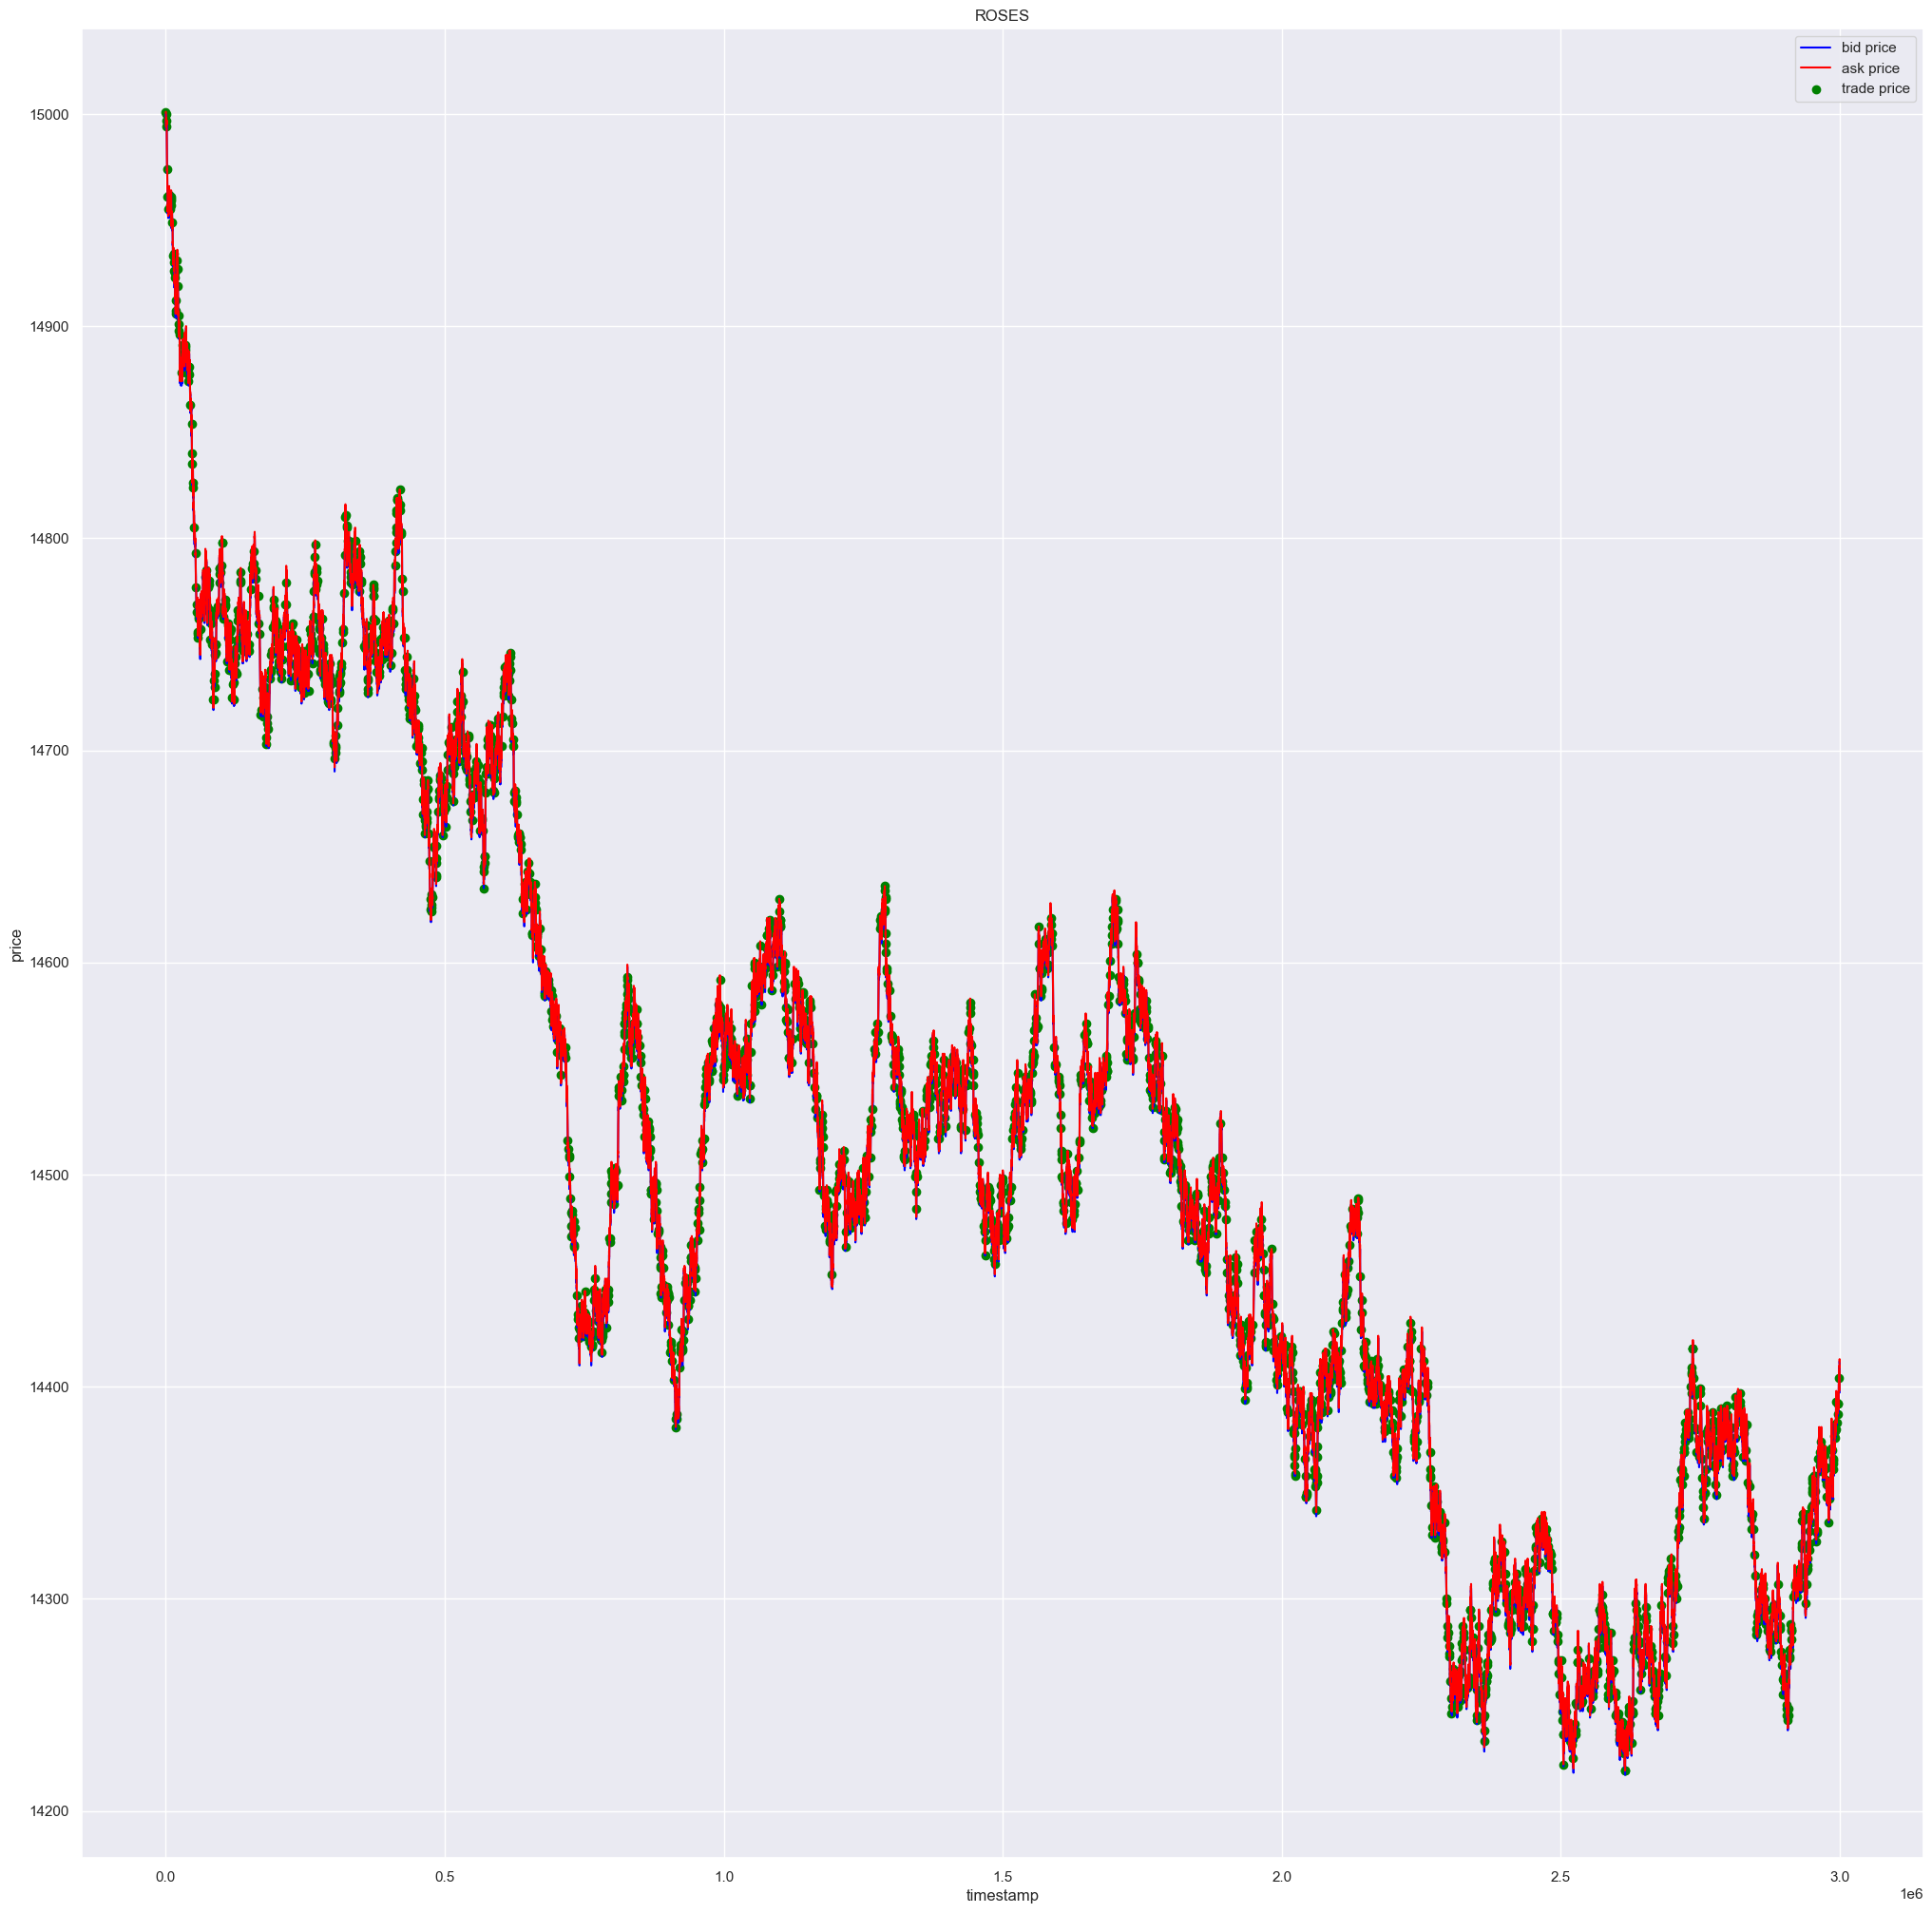

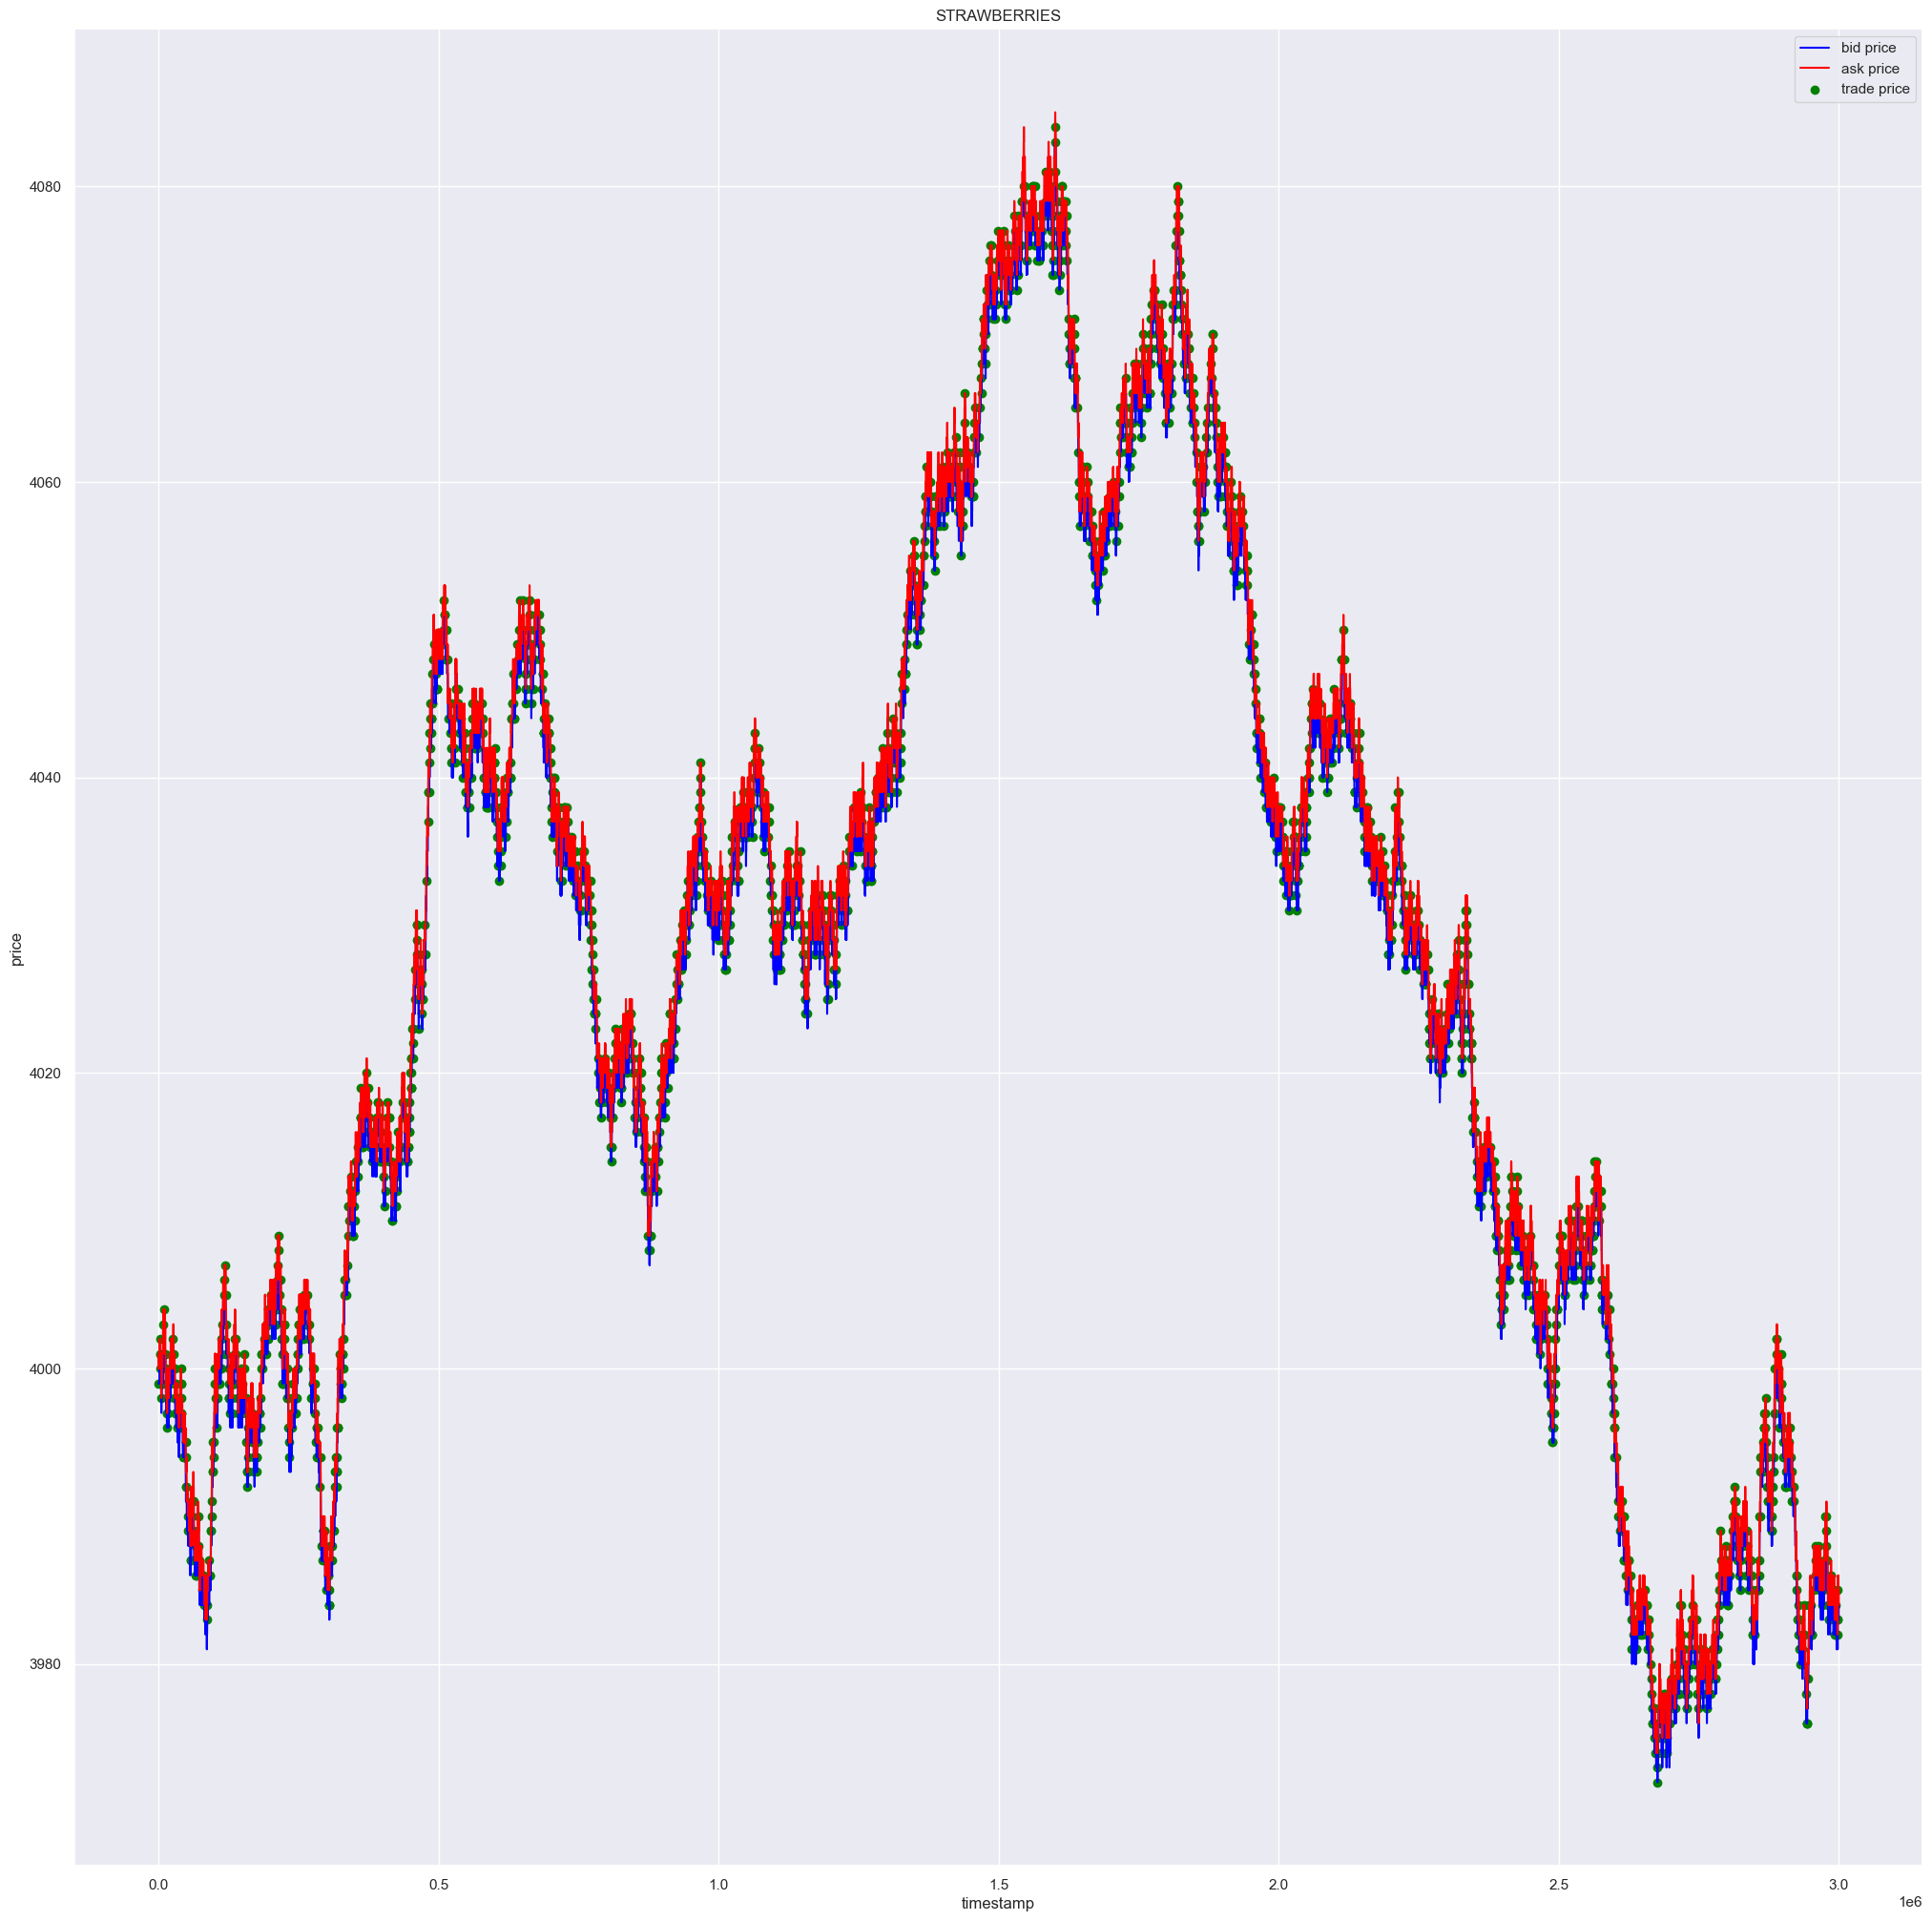

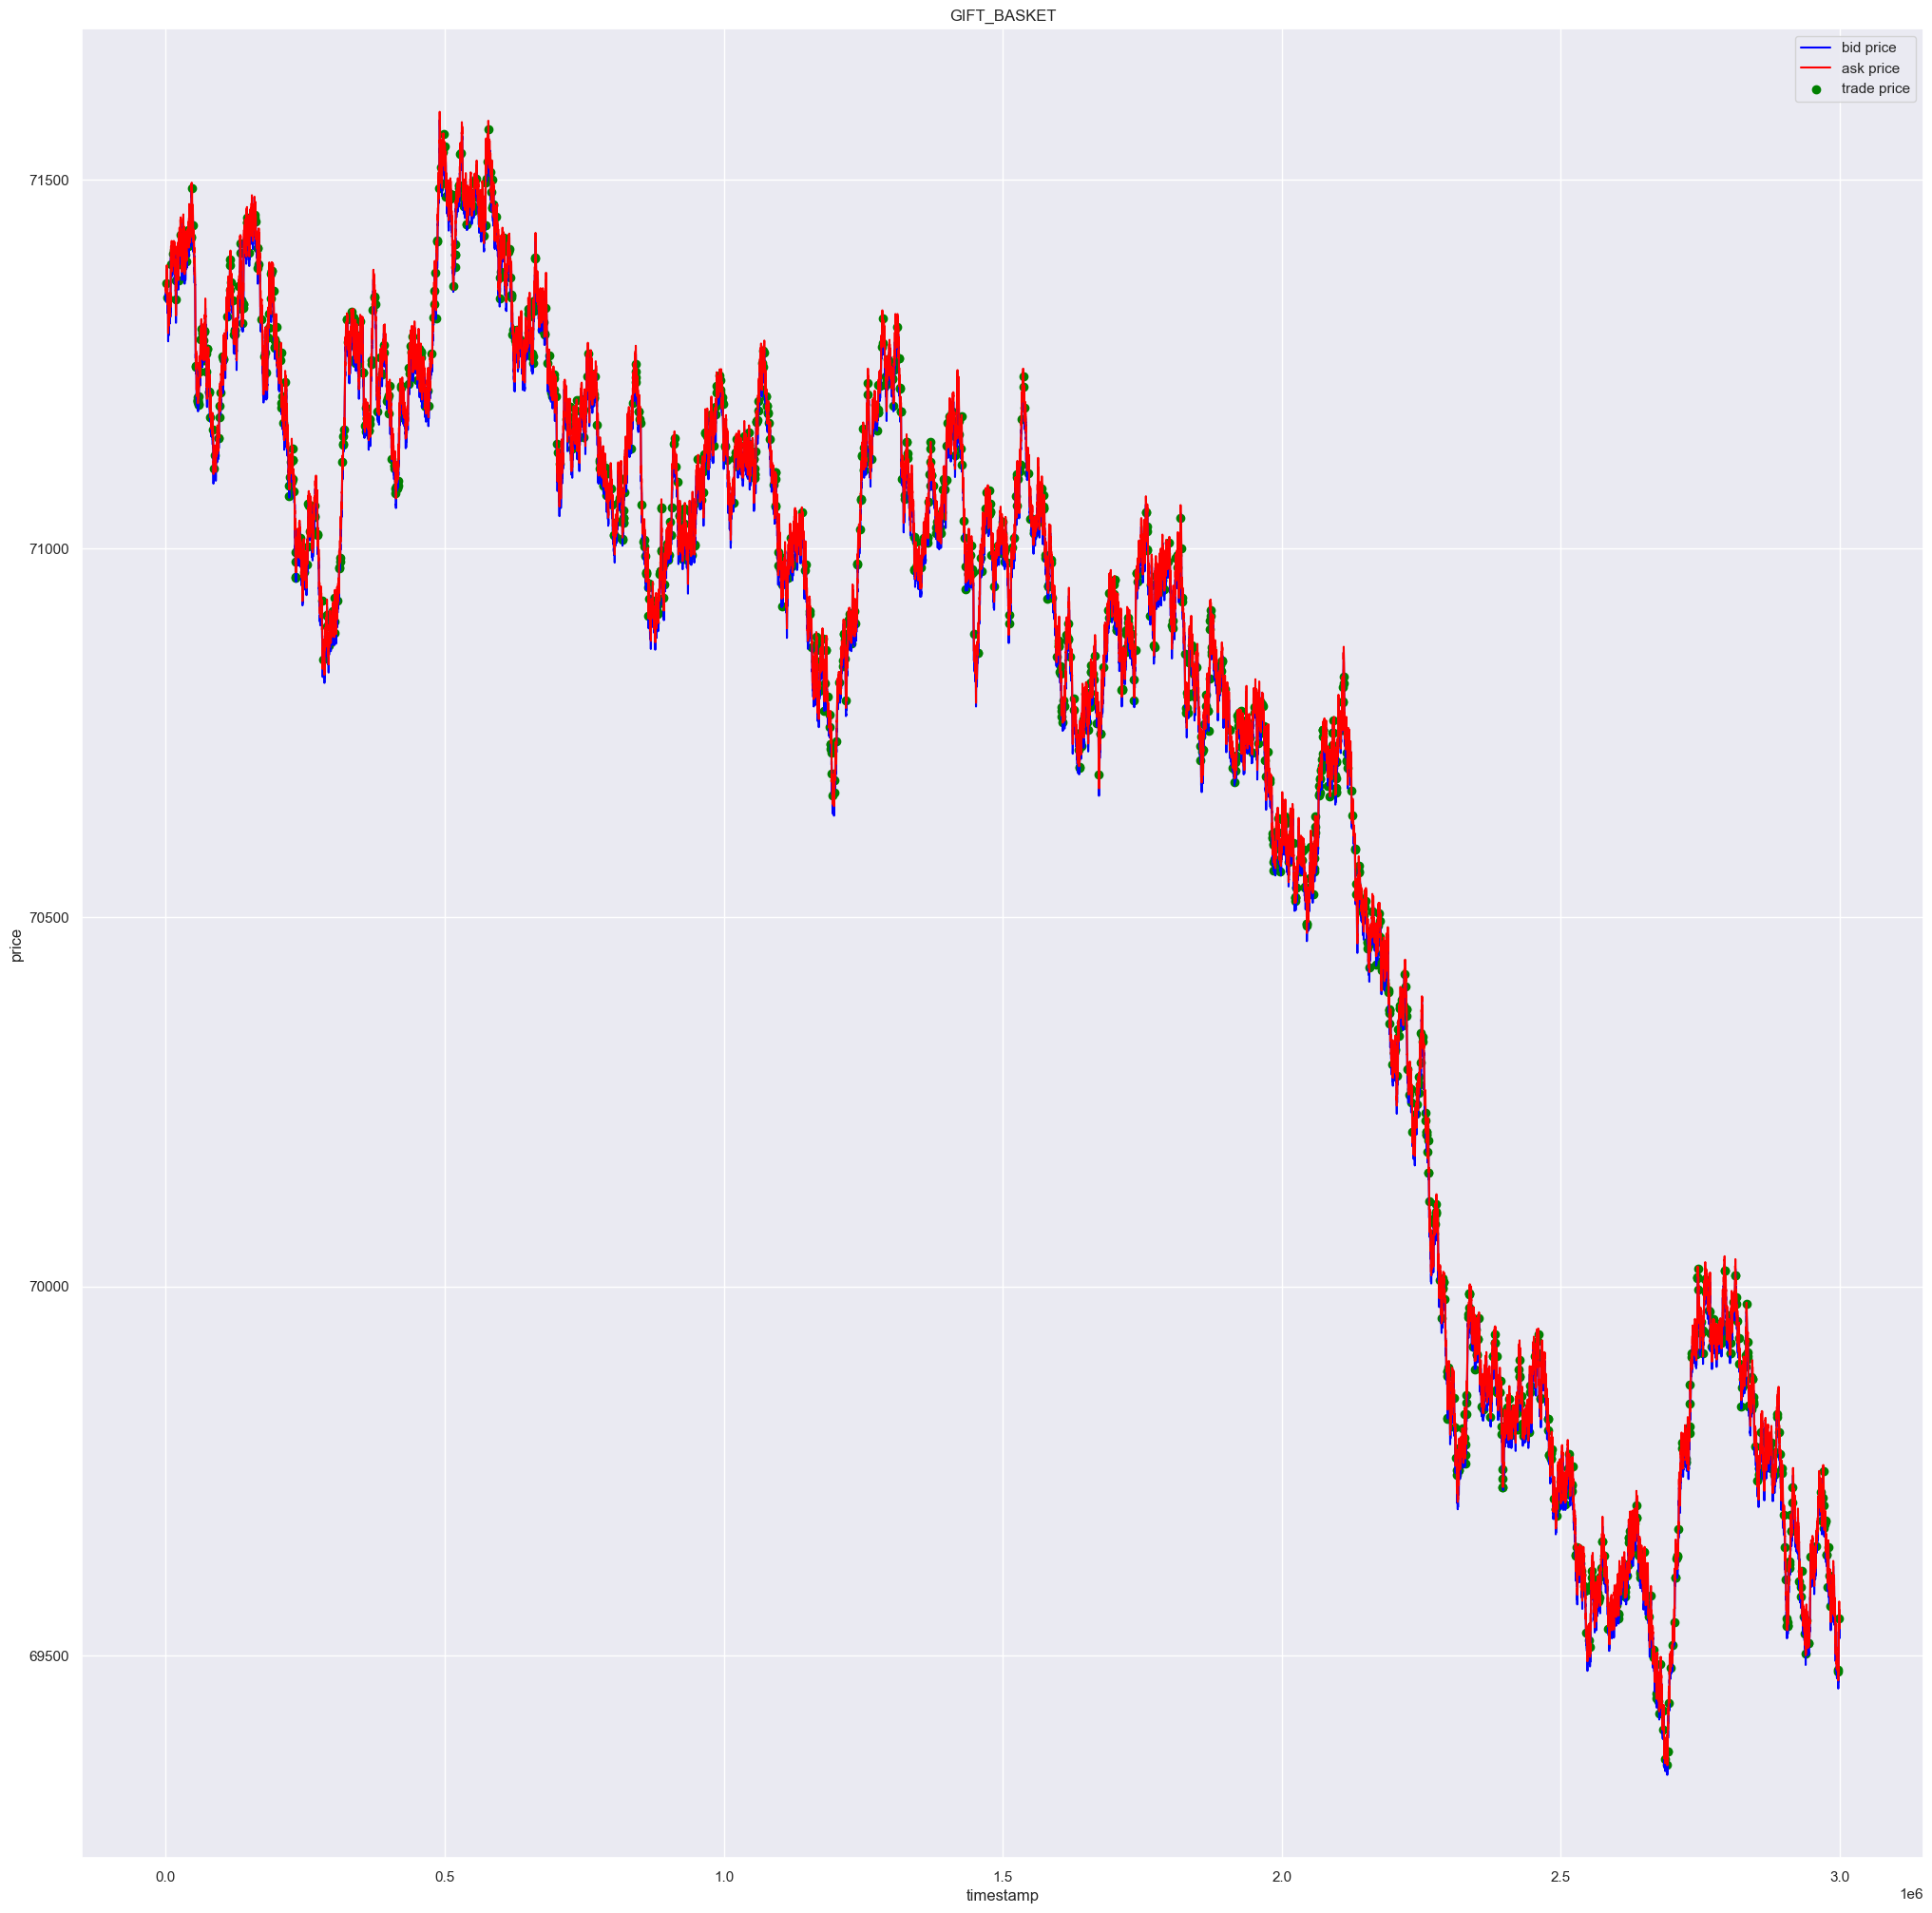

In [441]:
# plot all the bids, asks per product: CHOCOLATE, ROSES, STRAWBERRIES, and GIFT_BASKET

products = ["CHOCOLATE", "ROSES", "STRAWBERRIES", "GIFT_BASKET"]

for product in products:
    product_prices = prices[prices["product"] == product]
    product_trades = trades[trades["symbol"] == product]

    fig, ax = plt.subplots(figsize=(25,25))
    ax.plot(product_prices["timestamp"], product_prices["bid_price_1"], label="bid price", color="blue")
    ax.plot(product_prices["timestamp"], product_prices["ask_price_1"], label="ask price", color="red")
    ax.scatter(product_trades["timestamp"], product_trades["price"], label="trade price", color="green")
    ax.set_title(product)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("price")
    ax.legend()
    plt.show()

/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_33037/3775005905.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basket_prices["underlying_value"] = 4 * chocolate_prices["mid_price"] + rose_prices["mid_price"] + 6 * strawberry_prices["mid_price"]


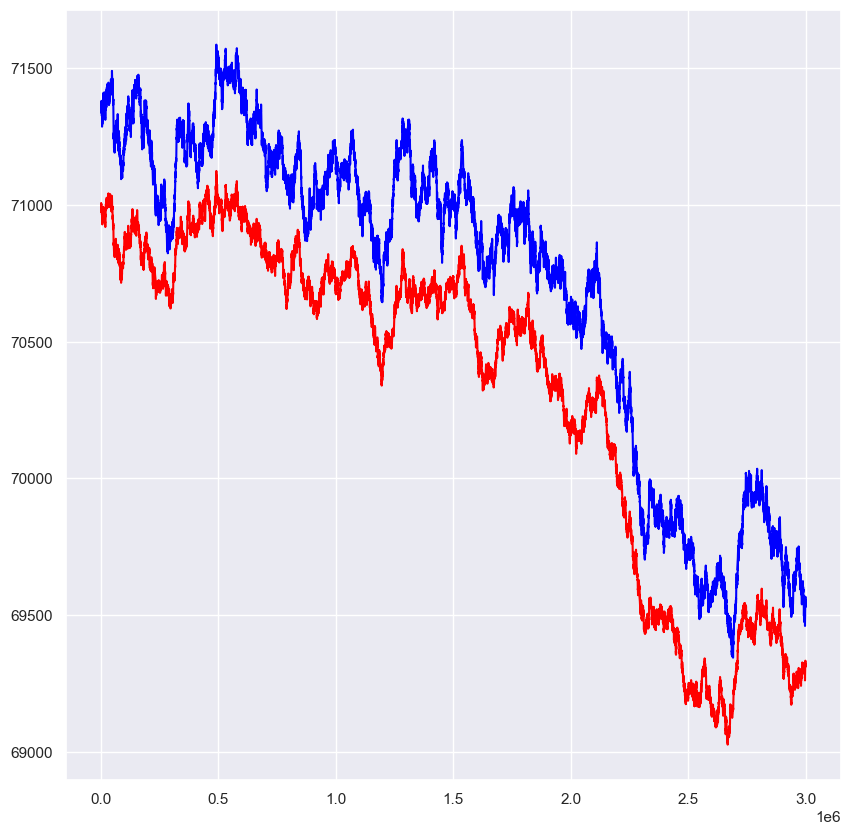

In [442]:
# Plot the price of the basket vs the value of the underlying products: 4 chocolates, 1 rose, 3 strawberries

# set index to timestamp
prices.set_index("timestamp", inplace=True)

chocolate_prices = prices[prices["product"] == "CHOCOLATE"]
# calculate ema for chocolate prices

rose_prices = prices[prices["product"] == "ROSES"]

strawberry_prices = prices[prices["product"] == "STRAWBERRIES"]

basket_prices = prices[prices["product"] == "GIFT_BASKET"]

basket_prices["underlying_value"] = 4 * chocolate_prices["mid_price"] + rose_prices["mid_price"] + 6 * strawberry_prices["mid_price"]

# basket_prices["value_ratio"] = basket_prices["mid_price"] / basket_prices["underlying_value"]

# reset index
prices.reset_index(inplace=True)

basket_prices.reset_index(inplace=True)
# plot the underlying value of the basket vs the price of the basket over timestamp

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_prices["timestamp"], basket_prices["mid_price"], label="basket price", color="blue")
ax.plot(basket_prices["timestamp"], basket_prices["underlying_value"], label="underlying value", color="red")


/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_33037/4257032290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basket_prices["value_ratio"] = basket_prices["mid_price"] - basket_prices["underlying_value"]


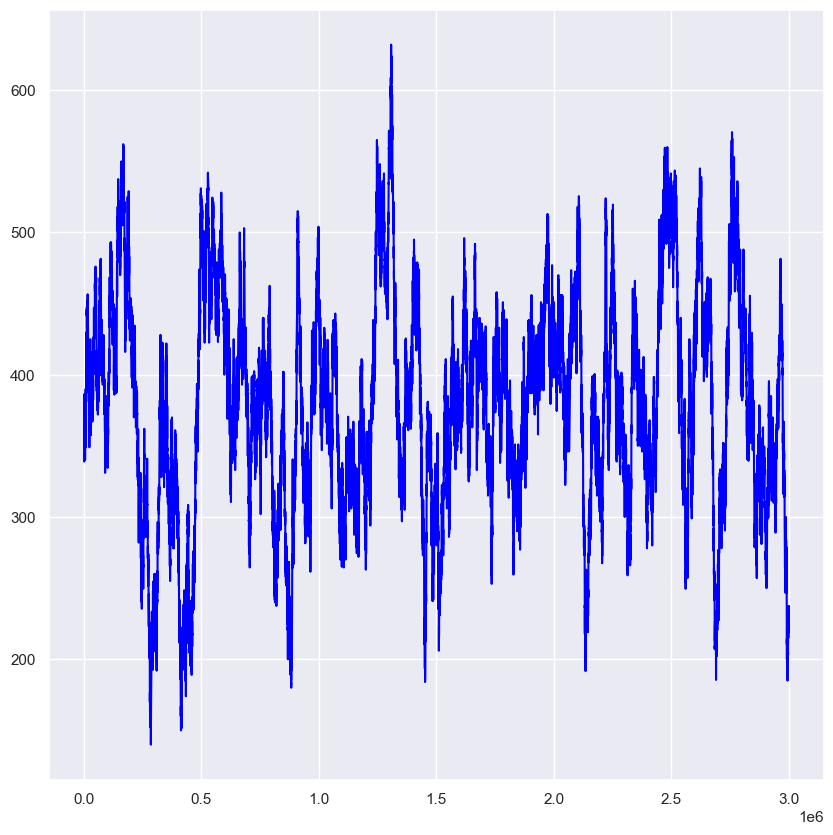

In [443]:
basket_prices["value_ratio"] = basket_prices["mid_price"] - basket_prices["underlying_value"]

# plot the ratio of the basket price to the underlying value
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_prices["timestamp"], basket_prices["value_ratio"], label="basket price / underlying value", color="blue")

# get the mean of the 


# Linear Regression

In [444]:

trades_d0 = pd.read_csv('data/trades_round_3_day_0_nn.csv', delimiter=';')
trades_d1 = pd.read_csv('data/trades_round_3_day_1_nn.csv', delimiter=';')
trades_d1["timestamp"] += trades_d0["timestamp"].iloc[-1] + 100
trades_d2 = pd.read_csv('data/trades_round_3_day_2_nn.csv', delimiter=';')
trades_d2["timestamp"] += trades_d1["timestamp"].iloc[-1] + 100

trades = pd.concat([trades_d0, trades_d1, trades_d2])



prices_d0 = pd.read_csv('data/prices_round_3_day_0.csv', delimiter=';')
prices_d1 = pd.read_csv('data/prices_round_3_day_1.csv', delimiter=';')
prices_d1["timestamp"] += prices_d0["timestamp"].iloc[-1] + 100
prices_d2 = pd.read_csv('data/prices_round_3_day_2.csv', delimiter=';')
prices_d2["timestamp"] += prices_d1["timestamp"].iloc[-1] + 100

prices = pd.concat([prices_d0, prices_d1, prices_d2])


chocolate_data = trades[trades["symbol"] == "CHOCOLATE"]

In [445]:


trades['total'] = trades['price'] * trades['quantity']
trades.rename(columns={'symbol':'product'}, inplace = True)
trade_summary = trades.groupby(['timestamp','product']).agg({'quantity':'sum', 'total':'sum'})
trade_summary = trade_summary.groupby(['product'])[['quantity','total']].cumsum()
trade_summary['vwap'] = trade_summary['total']/ trade_summary['quantity']
trade_summary.groupby(['product'])[['quantity','total']].cumsum()

trade_summary.reset_index(inplace = True)


In [446]:
# print headers of trade_summary


In [447]:

data = pd.merge(prices, trade_summary, on = ['timestamp','product'], how="left")

data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
data['vwap'] = data.groupby('product')['vwap'].fillna(data['mid_price'])
data[['quantity','total','vwap']] = data.groupby('product')[['quantity','total','vwap']].shift()
data.set_index('timestamp', inplace = True)
data[['bid_volume_1','bid_volume_2','bid_volume_3','ask_volume_1','ask_volume_2','ask_volume_3']] = data[['bid_volume_1','bid_volume_2','bid_volume_3','ask_volume_1','ask_volume_2','ask_volume_3']].fillna(0)

/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_33037/148032367.py:3: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_33037/148032367.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_33037/148032367.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling i

In [448]:
data['total_bid_volume'] = data[['bid_volume_1','bid_volume_2','bid_volume_3']].sum(axis = 1)
data['total_ask_volume'] = data[['ask_volume_1','ask_volume_2','ask_volume_3']].sum(axis = 1)

In [449]:
data['imbalance'] = (data['total_bid_volume'] - data['total_ask_volume']) / (data['total_bid_volume'] + data['total_ask_volume'])
data['spread'] = data['ask_price_1'] - data['bid_price_1'] 

In [450]:
product = ["CHOCOLATE", "ROSES", "STRAWBERRIES", "GIFT_BASKET"]
# product = "CHOCOLATE"

In [451]:
def get_train(product):
    data_train = data[data["product"] == product]
    data_train = data_train[['mid_price','imbalance','spread','vwap']]
    data_train['mid_price_1'] = data_train['mid_price'].shift(1)
    data_train['mid_price_2'] = data_train['mid_price'].shift(2)
    data_train['mid_price_3'] = data_train['mid_price'].shift(3)
    data_train['imbalance_1'] = data_train['imbalance'].shift(1)
    data_train['spread_1'] = data_train['spread'].shift(1)
    data_train['vwap_1'] = data_train['vwap'].shift(1)
    data_train = data_train[['mid_price_3','mid_price_2','mid_price_1','mid_price','imbalance_1','imbalance','spread_1','spread','vwap_1','vwap']]
    return data_train

In [452]:
data_train = get_train('CHOCOLATE')
X_train = data_train[3:20000]
y_train = data_train['mid_price'].shift(-1)[3:20000]
X_test, y_test = data_train[20000:-1], data_train['mid_price'].shift(-1)[20000:-1]

In [453]:
def objective(trial, X_train, y_train, X_val, y_val) -> float:
    '''
    The oobjective function for the optimisation problem.
    
    Args:
        trial: optuna.trial object
        X_train: ndarray or DataFrame, The features of training dataset
        y_train: Index or array-like, The Target of training dataset
        X_val: ndarray or DataFrame, The features of validation dastaset
        y_val: Index or array-like, The Target of validation dataset

    Returns:
        numeric, the performance mertic for the model training
    '''
    # the parameters you want to optimise and the sapce you wanna search
    param_grid = {
        'alpha': trial.suggest_float('alpha', 1e-15, 10.0, log = True),
    }
    model =  Ridge(**param_grid,
                #    fit_intercept= False
                   )
    
    model.fit(
        X_train,
        y_train
    )
    
    coef = model.coef_
    intercept = model.intercept_
    
    y_pred = model.predict(X_val)
    
    # profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
    mse = mean_squared_error(y_val, y_pred)
    return mse

def hyper_tune(X_train, y_train, direction="minimize", n_trials=30, test_size=0.3):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
    study_name="Linear Regression"
    direction=direction # maximize or minimize
    n_trials=n_trials

    study = optuna.create_study(direction=direction, study_name=study_name)
    func = lambda trial: objective(trial, X_train, y_train, X_val, y_val)
    study.optimize(func, n_trials=n_trials)
    return study

In [454]:
study = hyper_tune(X_train, y_train)

[I 2024-04-17 22:01:08,712] A new study created in memory with name: Linear Regression
[I 2024-04-17 22:01:08,718] Trial 0 finished with value: 1.0733743384641474 and parameters: {'alpha': 1.919781567764932e-05}. Best is trial 0 with value: 1.0733743384641474.
[I 2024-04-17 22:01:08,742] Trial 1 finished with value: 1.0733676209002285 and parameters: {'alpha': 0.24529967908214678}. Best is trial 1 with value: 1.0733676209002285.
[I 2024-04-17 22:01:08,752] Trial 2 finished with value: 1.0733743439071204 and parameters: {'alpha': 3.880331480174567e-15}. Best is trial 1 with value: 1.0733676209002285.
[I 2024-04-17 22:01:08,767] Trial 3 finished with value: 1.0733741356571493 and parameters: {'alpha': 0.0007380101339101397}. Best is trial 1 with value: 1.0733676209002285.
[I 2024-04-17 22:01:08,775] Trial 4 finished with value: 1.073374343907133 and parameters: {'alpha': 2.433532443581948e-13}. Best is trial 1 with value: 1.0733676209002285.
[I 2024-04-17 22:01:08,782] Trial 5 finished w

In [455]:
model =  Ridge(**study.best_params
               , fit_intercept= False
               )

model.fit(
    X_train,
    y_train
)

Ridge(alpha=0.12486778436219215, fit_intercept=False)

In [456]:
y_pred = model.predict(X_test)

# profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
mse = mean_squared_error(y_test, y_pred)

In [457]:
model.score(X_test, y_test)

0.9996609925922748

In [458]:
model.coef_

array([-0.00439101,  0.00309246,  0.01755208,  0.98358155, -0.85506432,
       -2.65057722,  0.02711992, -0.00314853,  0.11346829, -0.11330898])

In [459]:
# all models have no intercept, i.e.  intecept = 0
CHOCOLATE = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322,
       -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]
ROSES = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577 ,
       -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]
STRAWBERRIES = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083,
       -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]
GIFT_BASKET = [-4.93091977e-03,  2.60248787e-03,  8.98806498e-03,  9.92372840e-01,
       -8.29595831e-02,  8.40848233e+00, -3.31841259e-02,  2.30186523e-02,
       -1.88540730e-01,  1.89507642e-01]


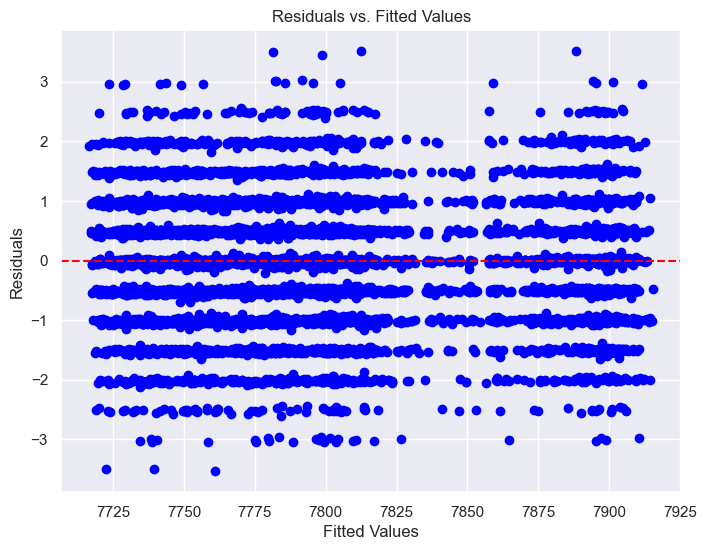

In [460]:
import statsmodels.api as sm

# Residual plot
residuals = y_test - y_pred

# Create the Residuals vs. Fitted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [461]:
# calculate predicted values for each product 

# CHOCOLATE = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322,
#           -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]
# ROSES = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577 ,
#        -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]
# STRAWBERRIES = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083,
#        -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]

# def get_train(product):
#     data_train = data[data["product"] == product]
#     data_train = data_train[['mid_price','imbalance','spread','vwap']]
#     data_train['mid_price_1'] = data_train['mid_price'].shift(1)
#     data_train['mid_price_2'] = data_train['mid_price'].shift(2)
#     data_train['mid_price_3'] = data_train['mid_price'].shift(3)
#     data_train['imbalance_1'] = data_train['imbalance'].shift(1)
#     data_train['spread_1'] = data_train['spread'].shift(1)
#     data_train['vwap_1'] = data_train['vwap'].shift(1)
#     data_train = data_train[['mid_price_3','mid_price_2','mid_price_1','mid_price','imbalance_1','imbalance','spread_1','spread','vwap_1','vwap']]
#     return data_train



    

basket_data = get_train("GIFT_BASKET")
    
intercept = 0

chocolate_coeff = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322, -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]

chocolate_data = get_train("CHOCOLATE")

basket_data["chocolate_predicted_price"] = chocolate_data["mid_price_3"] * chocolate_coeff[0] + chocolate_data["mid_price_2"] * chocolate_coeff[1] + chocolate_data["mid_price_1"] * chocolate_coeff[2] + chocolate_data["mid_price"] * chocolate_coeff[3] + chocolate_data["imbalance_1"] * chocolate_coeff[4] + chocolate_data["imbalance"] * chocolate_coeff[5] + chocolate_data["spread_1"] * chocolate_coeff[6] + chocolate_data["spread"] * chocolate_coeff[7] + chocolate_data["vwap_1"] * chocolate_coeff[8] + chocolate_data["vwap"] * chocolate_coeff[9] + intercept

strawberry_coeff = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083, -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]

strawberry_data = get_train("STRAWBERRIES")

basket_data["strawberry_predicted_price"] = strawberry_data["mid_price_3"] * strawberry_coeff[0] + strawberry_data["mid_price_2"] * strawberry_coeff[1] + strawberry_data["mid_price_1"] * strawberry_coeff[2] + strawberry_data["mid_price"] * strawberry_coeff[3] + strawberry_data["imbalance_1"] * strawberry_coeff[4] + strawberry_data["imbalance"] * strawberry_coeff[5] + strawberry_data["spread_1"] * strawberry_coeff[6] + strawberry_data["spread"] * strawberry_coeff[7] + strawberry_data["vwap_1"] * strawberry_coeff[8] + strawberry_data["vwap"] * strawberry_coeff[9] + intercept


roses_coeff = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577, -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]

roses_data = get_train("ROSES")

basket_data["roses_predicted_price"] = roses_data["mid_price_3"] * roses_coeff[0] + roses_data["mid_price_2"] * roses_coeff[1] + roses_data["mid_price_1"] * roses_coeff[2] + roses_data["mid_price"] * roses_coeff[3] + roses_data["imbalance_1"] * roses_coeff[4] + roses_data["imbalance"] * roses_coeff[5] + roses_data["spread_1"] * roses_coeff[6] + roses_data["spread"] * roses_coeff[7] + roses_data["vwap_1"] * roses_coeff[8] + roses_data["vwap"] * roses_coeff[9] + intercept

basket_data["chocolate_predicted_price_1"] = basket_data["chocolate_predicted_price"].shift(1)
basket_data["strawberry_predicted_price_1"] = basket_data["strawberry_predicted_price"].shift(1)
basket_data["roses_predicted_price_1"] = basket_data["roses_predicted_price"].shift(1)

basket_data["imbalance_1"] = basket_data["imbalance"].shift(1)
basket_data["spread_1"] = basket_data["spread"].shift(1)
basket_data["vwap_1"] = basket_data["vwap"].shift(1)
basket_data["midprice_1"] = basket_data["mid_price"].shift(1)


basket_data = basket_data[['mid_price', 'imbalance', 'imbalance_1','spread', 'spread_1', 'vwap', 'vwap_1', 'chocolate_predicted_price', 'chocolate_predicted_price_1', 'strawberry_predicted_price', 'strawberry_predicted_price_1', 'roses_predicted_price_1', 'roses_predicted_price', ]]

# remove nan
basket_data = basket_data.dropna()

In [462]:
X_train = basket_data[3:20000]
y_train = basket_data['mid_price'].shift(-1)[3:20000]
X_test, y_test = basket_data[20000:-1], basket_data['mid_price'].shift(-1)[20000:-1]

In [463]:
study = hyper_tune(X_train, y_train, n_trials=100)

[I 2024-04-17 22:01:09,490] A new study created in memory with name: Linear Regression
[I 2024-04-17 22:01:09,499] Trial 0 finished with value: 63.77126804136896 and parameters: {'alpha': 1.6539871612074054e-13}. Best is trial 0 with value: 63.77126804136896.
[I 2024-04-17 22:01:09,512] Trial 1 finished with value: 63.7712680413629 and parameters: {'alpha': 1.5423166718369472e-15}. Best is trial 1 with value: 63.7712680413629.
[I 2024-04-17 22:01:09,525] Trial 2 finished with value: 63.7712680413629 and parameters: {'alpha': 1.9350051785818852e-15}. Best is trial 1 with value: 63.7712680413629.
[I 2024-04-17 22:01:09,530] Trial 3 finished with value: 63.772884505547076 and parameters: {'alpha': 2.900176045056718}. Best is trial 1 with value: 63.7712680413629.
[I 2024-04-17 22:01:09,537] Trial 4 finished with value: 63.771268041376295 and parameters: {'alpha': 3.0772244767777726e-08}. Best is trial 1 with value: 63.7712680413629.
[I 2024-04-17 22:01:09,552] Trial 5 finished with value: 

In [464]:
model =  Ridge(**study.best_params
               , fit_intercept= False
               )

model.fit(
    X_train,
    y_train
)


y_pred = model.predict(X_test)

# profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
mse = mean_squared_error(y_test, y_pred)


model.score(X_test, y_test)

0.9995392366025359

In [465]:
model.coef_


array([ 0.99637084,  8.54381396, -0.161608  ,  0.02234559, -0.03371232,
        0.21668808, -0.21632859,  0.04613577, -0.03263618, -0.02076174,
        0.04016784, -0.02797431,  0.03116055])

In [466]:
SCORE = 0.9995392366025357
BASKET_PRICE = [ 0.99637084,  8.54381396, -0.161608  ,  0.02234559, -0.03371232, 0.21668808, -0.21632859,  0.04613577, -0.03263618, -0.02076174, 0.04016784, -0.02797431,  0.03116055]

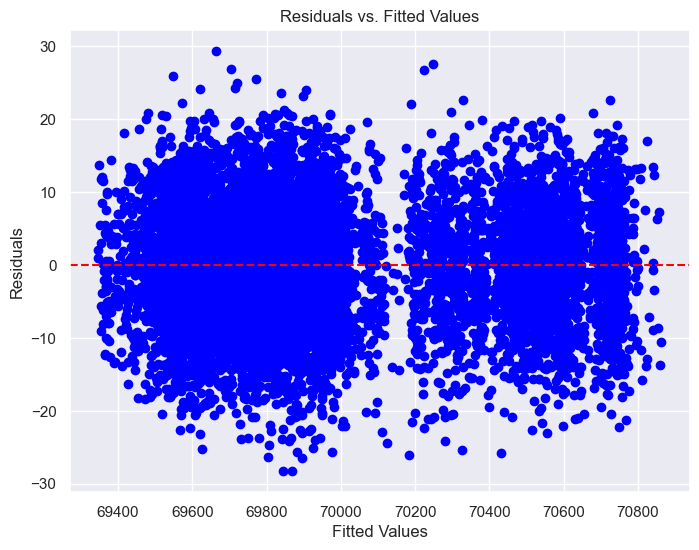

In [467]:
import statsmodels.api as sm

# Residual plot
residuals = y_test - y_pred

# Create the Residuals vs. Fitted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [468]:
# plot the predicted midprice v timestamp 


basket_data["predicted_midprice"] = model.predict(basket_data)

basket_data["underlying_value"] = 4 * basket_data["chocolate_predicted_price"] + basket_data["roses_predicted_price"] + 6 * basket_data["strawberry_predicted_price"]


basket_data["mid_price_diff"] = basket_data["underlying_value"] - basket_data["predicted_midprice"]

# Predicted mid price vs underlying value 



In [469]:
# # plot predicted vs actual midprice

# fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(basket_data.index, basket_data["mid_price"], label="actual mid price", color="blue")
# ax.plot(basket_data.index, basket_data["predicted_midprice"], label="predicted mid price", color="red")

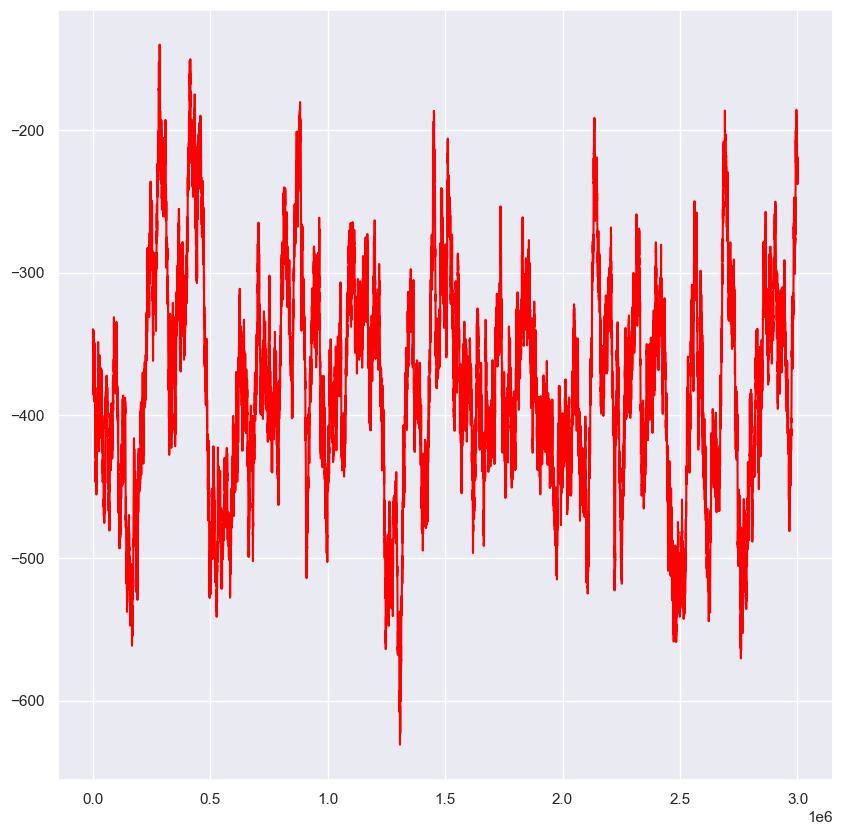

In [470]:

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_data.index, basket_data["mid_price_diff"], label="predicted mid price", color="red")





In [471]:
GIFT_BASKET = [9.96390319e-01, 8.48919748e+00, 2.23259588e-02, 1.46613902e-02, 2.19682410e-02, 3.47660363e-03]

# BASKET STRATEGY

In [472]:
diff = prices.query('product == "GIFT_BASKET"').mid_price.reset_index(drop=True) - prices.query('product == "CHOCOLATE"').mid_price.reset_index(drop=True) * 4 - prices.query('product == "STRAWBERRIES"').mid_price.reset_index(drop=True) * 6 - prices.query('product == "ROSES"').mid_price.reset_index(drop=True)

In [473]:
prices.query('product == "CHOCOLATES"').mid_price.reset_index(drop=True)

Series([], Name: mid_price, dtype: float64)

In [474]:
prices

day  timestamp       product  bid_price_1  bid_volume_1  bid_price_2  \
0        0          0     CHOCOLATE         7999           111          NaN   
1        0          0  STRAWBERRIES         3999           210          NaN   
2        0          0         ROSES        14999            72          NaN   
3        0          0   GIFT_BASKET        71348            19      71347.0   
4        0        100   GIFT_BASKET        71344             1      71343.0   
...    ...        ...           ...          ...           ...          ...   
39995    2    2999800   GIFT_BASKET        69537             2      69536.0   
39996    2    2999900     CHOCOLATE         7749           143          NaN   
39997    2    2999900   GIFT_BASKET        69551             1      69550.0   
39998    2    2999900  STRAWBERRIES         3984           240          NaN   
39999    2    2999900         ROSES        14411            59          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0               NaN          NaN           NaN         8001           111   
1               NaN          NaN           NaN         4001           210   
2               NaN          NaN           NaN        15001            72   
3              24.0          NaN           NaN        71362            19   
4              12.0      71342.0          20.0        71355             1   
...             ...          ...           ...          ...           ...   
39995          18.0      69535.0          24.0        69547             2   
39996           NaN          NaN           NaN         7751           143   
39997          19.0      69549.0          20.0        69561             1   
39998           NaN          NaN           NaN         3985            92   
39999           NaN          NaN           NaN        14412            59   

       ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0              NaN           NaN          NaN           NaN     8000.0   
1              NaN           NaN          NaN           NaN     4000.0   
2              NaN           NaN          NaN           NaN    15000.0   
3          71363.0          24.0          NaN           NaN    71355.0   
4          71356.0          12.0      71357.0          20.0    71349.5   
...            ...           ...          ...           ...        ...   
39995      69548.0          18.0      69550.0          24.0    69542.0   
39996          NaN           NaN          NaN           NaN     7750.0   
39997      69562.0          19.0      69564.0          20.0    69556.0   
39998       3986.0         148.0          NaN           NaN     3984.5   
39999          NaN           NaN          NaN           NaN    14411.5   

       profit_and_loss  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
39995              0.0  
39996              0.0  
39997              0.0  
39998              0.0  
39999              0.0  

[120000 rows x 17 columns]

In [475]:

# left merge the trades onto the prices 

prices = pd.merge(prices, trades, on = ['timestamp','product'], how="left")

prices['midpoint_difference'] = prices['mid_price'] - prices['price']
prices

day  timestamp       product  bid_price_1  bid_volume_1  bid_price_2  \
0         0          0     CHOCOLATE         7999           111          NaN   
1         0          0  STRAWBERRIES         3999           210          NaN   
2         0          0         ROSES        14999            72          NaN   
3         0          0   GIFT_BASKET        71348            19      71347.0   
4         0        100   GIFT_BASKET        71344             1      71343.0   
...     ...        ...           ...          ...           ...          ...   
120469    2    2999800   GIFT_BASKET        69537             2      69536.0   
120470    2    2999900     CHOCOLATE         7749           143          NaN   
120471    2    2999900   GIFT_BASKET        69551             1      69550.0   
120472    2    2999900  STRAWBERRIES         3984           240          NaN   
120473    2    2999900         ROSES        14411            59          NaN   

        bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
0                NaN          NaN           NaN         8001  ...   
1                NaN          NaN           NaN         4001  ...   
2                NaN          NaN           NaN        15001  ...   
3               24.0          NaN           NaN        71362  ...   
4               12.0      71342.0          20.0        71355  ...   
...              ...          ...           ...          ...  ...   
120469          18.0      69535.0          24.0        69547  ...   
120470           NaN          NaN           NaN         7751  ...   
120471          19.0      69549.0          20.0        69561  ...   
120472           NaN          NaN           NaN         3985  ...   
120473           NaN          NaN           NaN        14412  ...   

        ask_volume_3  mid_price  profit_and_loss  buyer  seller   currency  \
0                NaN     8000.0              0.0    NaN     NaN  SEASHELLS   
1                NaN     4000.0              0.0    NaN     NaN        NaN   
2                NaN    15000.0              0.0    NaN     NaN  SEASHELLS   
3                NaN    71355.0              0.0    NaN     NaN        NaN   
4               20.0    71349.5              0.0    NaN     NaN        NaN   
...              ...        ...              ...    ...     ...        ...   
120469          24.0    69542.0              0.0    NaN     NaN        NaN   
120470           NaN     7750.0              0.0    NaN     NaN        NaN   
120471          20.0    69556.0              0.0    NaN     NaN        NaN   
120472           NaN     3984.5              0.0    NaN     NaN        NaN   
120473           NaN    14411.5              0.0    NaN     NaN        NaN   

          price  quantity    total midpoint_difference  
0        8001.0       8.0  64008.0                -1.0  
1           NaN       NaN      NaN                 NaN  
2       15001.0       3.0  45003.0                -1.0  
3           NaN       NaN      NaN                 NaN  
4           NaN       NaN      NaN                 NaN  
...         ...       ...      ...                 ...  
120469      NaN       NaN      NaN                 NaN  
120470      NaN       NaN      NaN                 NaN  
120471      NaN       NaN      NaN                 NaN  
120472      NaN       NaN      NaN                 NaN  
120473      NaN       NaN      NaN                 NaN  

[120474 rows x 24 columns]

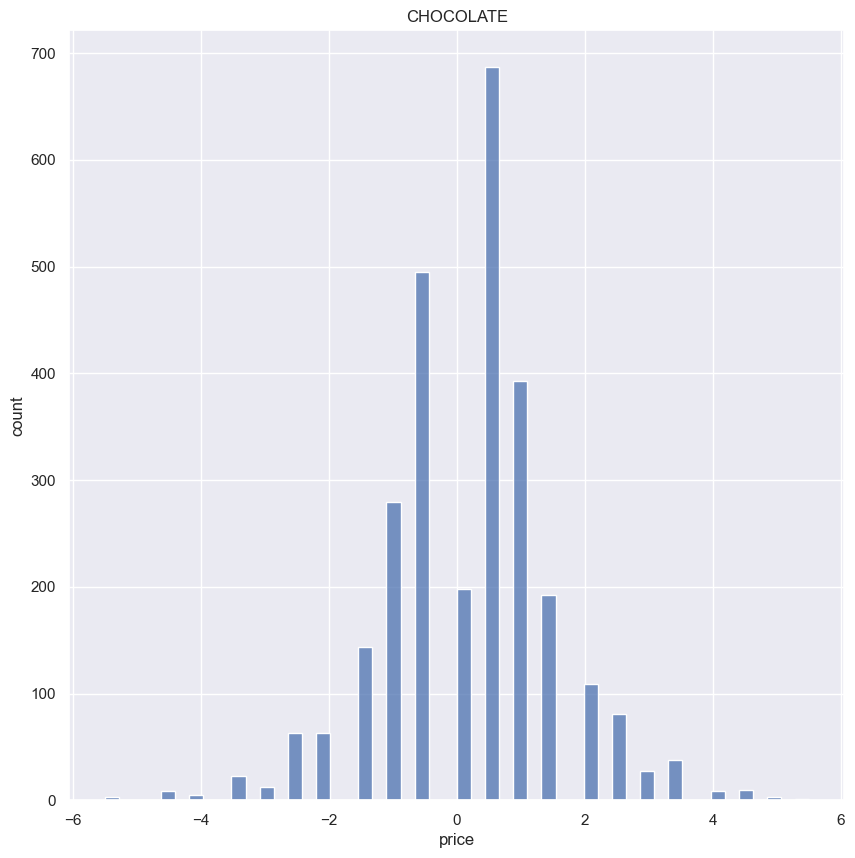

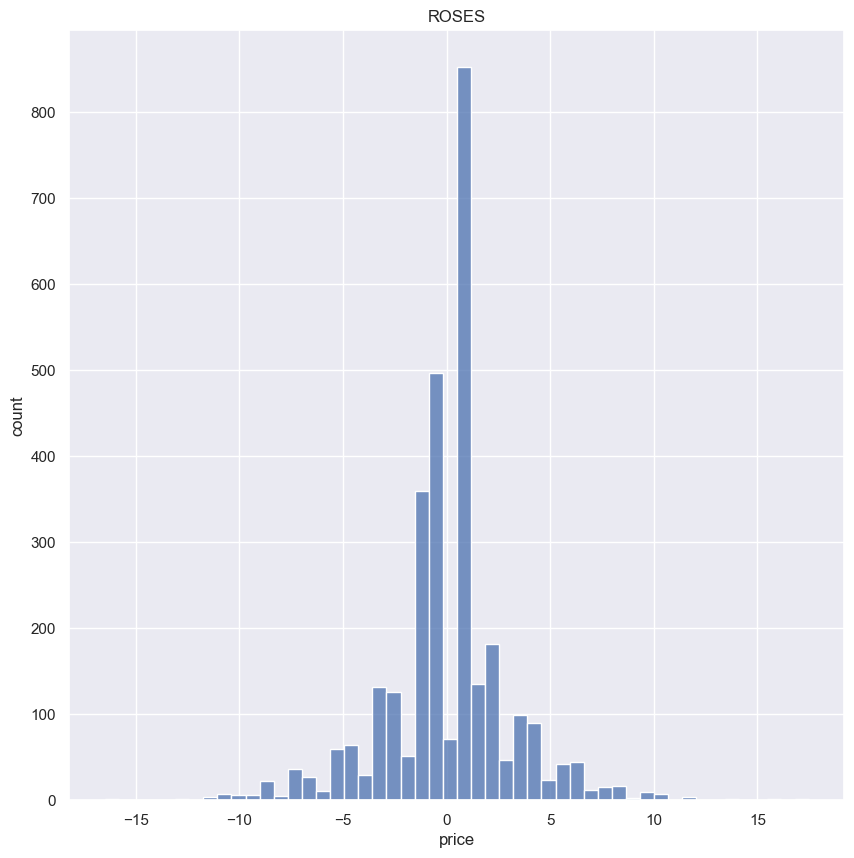

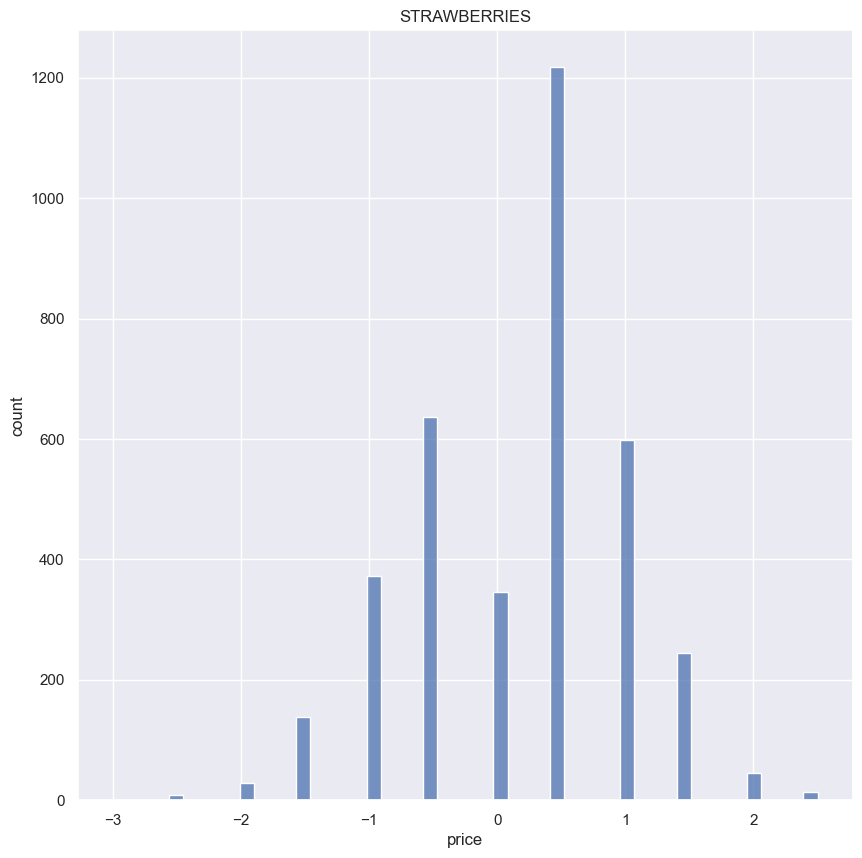

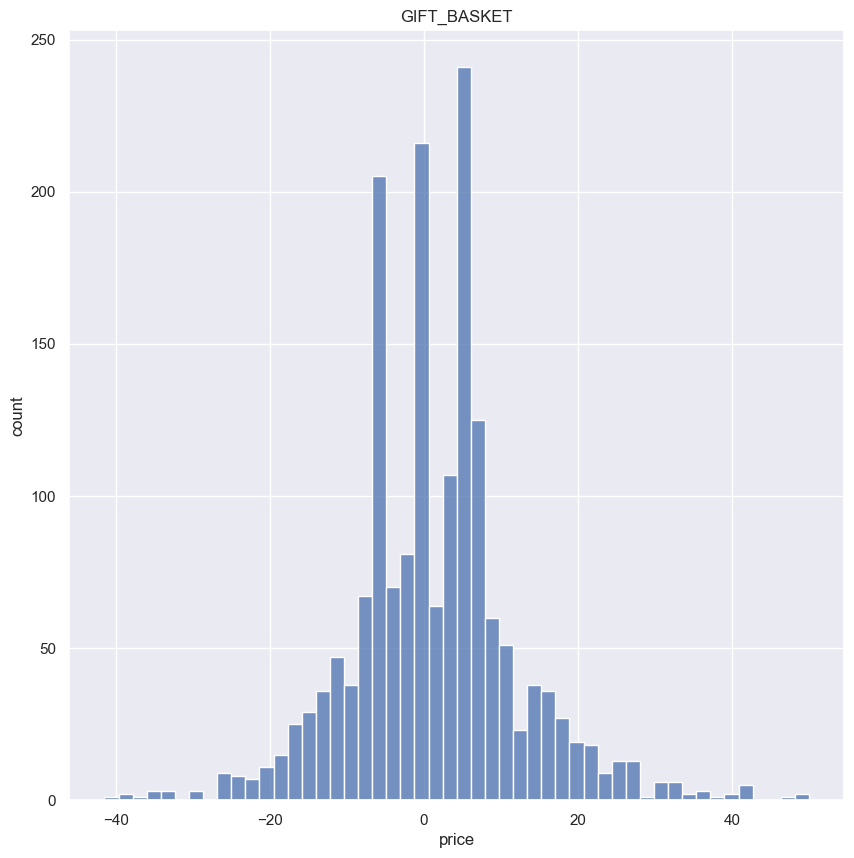

In [476]:
# get the count for each unique price for each product


#plot the price distribution for each product

for product in products:
    product_prices = prices[prices["product"] == product]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.histplot(product_prices["midpoint_difference"], ax=ax, bins=50)
    ax.set_title(product)
    ax.set_xlabel("price")
    ax.set_ylabel("count")
    plt.show()

In [477]:
# run dicker-fuller test on the price data

from statsmodels.tsa.stattools import adfuller


result = adfuller(basket_data["mid_price_diff"])

pd.Series(result[0:4], index=['ADF Statistic','p-value','# Lags','# Observations'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -6.449431633320687
p-value: 1.5365927764272266e-08
Critical Values:
	1%: -3.430568038932238
	5%: -2.8616363673136656
	10%: -2.5668212933804115


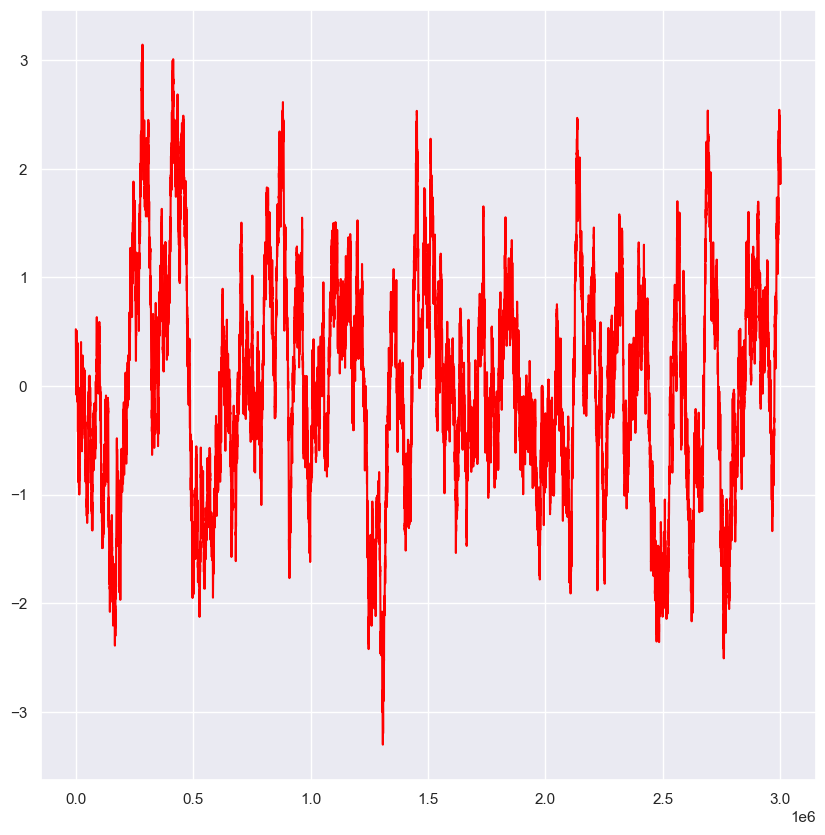

In [478]:
# We get the residuals (errors) from the previous regression and calculate the z-score 

basket_data["z_score"] = (basket_data["mid_price_diff"] - basket_data["mid_price_diff"].mean()) / basket_data["mid_price_diff"].std()

# plot the z-score v timestamp

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_data.index, basket_data["z_score"], label="z-score", color="red")


In [479]:
# When z-score is >0, we long on the basket and short the underlying products

# when z-score is <0, we short the basket and long the underlying products

# Follow this:

# https://www.quantifiedstrategies.com/pairs-trading-strategy-python/
# https://medium.com/@kw3181/statistical-arbitrage-1-pairs-trading-with-robust-kalman-filter-and-hidden-markov-model-62d0a1a0e4ae

# hyper tuning the std multiper for the basket analysis

In [42]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../../../prosperity2bt/')

import hypertune
import round_3_train 
import optuna

In [53]:
from importlib import reload
reload(round_3_train)

<module 'round_3_train' from '/Users/Leo.Leung/code/IMC-trading/rounds/round_3/round_3_train.py'>

In [80]:
def objective(trial) -> float:
    '''
    The oobjective function for the optimisation problem.
    
    Args:
        trial: optuna.trial object
        X_train: ndarray or DataFrame, The features of training dataset
        y_train: Index or array-like, The Target of training dataset
        X_val: ndarray or DataFrame, The features of validation dastaset
        y_val: Index or array-like, The Target of validation dataset

    Returns:
        numeric, the performance mertic for the model training
    '''
    # the parameters you want to optimise and the sapce you wanna search
    multiper = trial.suggest_float('multiper', 0.1, 2)
    
    profit = hypertune.get_profit(round_3_train.Trader(multiper = 0.4, der_res = a, diff_thresh= b),'../../../prosperity2bt/resources')
    return profit

def hyper_tune(direction="maximize", n_trials=100):
    study_name="Linear Regression"
    direction=direction # maximize or minimize
    n_trials=n_trials

    study = optuna.create_study(direction=direction, study_name=study_name)
    func = lambda trial: objective(trial)
    study.optimize(func, n_trials=n_trials)
    return study

In [81]:
hyper_tune()

[I 2024-04-18 11:16:49,775] A new study created in memory with name: Linear Regression
[W 2024-04-18 11:16:49,778] Trial 0 failed with parameters: {'a': 175.20983622477854, 'b': 142} because of the following error: TypeError("Trader.__init__() got an unexpected keyword argument 'der_res'").
Traceback (most recent call last):
  File "/Users/Leo.Leung/Library/Python/3.11/lib/python/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/cb/3xpyndm50zq34mbkkt98j8l00000gq/T/ipykernel_33993/3411942977.py", line 28, in <lambda>
    func = lambda trial: objective(trial)
                         ^^^^^^^^^^^^^^^^
  File "/var/folders/cb/3xpyndm50zq34mbkkt98j8l00000gq/T/ipykernel_33993/3411942977.py", line 19, in objective
    profit = hypertune.get_profit(round_3_train.Trader(multiper = 0.4, der_res = a, diff_thresh= b),'../../../prosperity2bt/resources')
                                  ^^^^^^^^

TypeError: Trader.__init__() got an unexpected keyword argument 'der_res'

In [52]:
# buy sell seperately  training set: 217512.5
0.4136111734012503 
hypertune.get_profit2(round_3_train.Trader(multiper = 0.4136111734012503),'../../../prosperity2bt/resources')

73666.0

In [78]:
# using mid point  training set: 218501.5
0.3924279312472417
hypertune.get_profit2(round_3_train.Trader(multiper = 0.4),'../../../prosperity2bt/resources')

97374.0

In [79]:
hypertune.get_profit(round_3_train.Trader(multiper = 0.4),'../../../prosperity2bt/resources')

218350.5

In [72]:
218350.5 + 97374.0

315724.5

In [75]:
218501.5+94809.0

313310.5

In [101]:
prices.query('product == "STRAWBERRIES"').mid_price.std()

27.40603199413994

In [105]:
prices_d2.query('product == "STRAWBERRIES"').mid_price.std()

21.95996133034307

In [102]:
prices_d2.query('product == "STRAWBERRIES"').mid_price.std()

21.95996133034307

In [115]:
mid_price = prices.set_index('timestamp').query('product == "STRAWBERRIES"').mid_price
window = 40  # Choose a window size for moving average and std deviation
moving_avg = mid_price.rolling(window=window).mean()
std_dev = mid_price.rolling(window=window).std()*1.96

# Calculate upper and lower Bollinger Bands
upper_band = moving_avg + (std_dev * 1)  # 1 standard deviation above the moving average
lower_band = moving_avg - (std_dev * 1)  # 1 standard deviation below the moving average

# Plotting
plt.figure(figsize=(200, 80))
plt.plot(mid_price, label='Stock Price', color='blue')
plt.plot(moving_avg, label='Moving Average', color='black')
plt.plot(upper_band, label='Upper Band (1 SD)', linestyle='--', color='red')
plt.plot(lower_band, label='Lower Band (1 SD)', linestyle='--', color='green')
# plt.fill_between(dates, lower_band, upper_band, color='gray', alpha=0.1)
plt.title('Stock Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()